In [ ]:
# !cd C:\Users\ASUS\Downloads\Malware-classification

In [7]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install xgboost

     |████████████████████████████████| 4.5 MB 904 kB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


Before running this notebook, make sure to download the dataset first. The dataset used here is of Microsoft Malware Classification Challenge(2015), can be found in kaggle: https://www.kaggle.com/competitions/malware-classification

Before running this notebook, make sure to download the dataset first. The dataset used here is of Microsoft Malware Classification Challenge(2015), can be found in kaggle: https://www.kaggle.com/competitions/malware-classification

In [9]:
import warnings
warnings.filterwarnings("ignore")
import shutil
import os
import pandas as pd
import matplotlib
matplotlib.use(u'nbAgg')
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
from sklearn.manifold import TSNE
from sklearn import preprocessing
import pandas as pd
from multiprocessing import Process# this is used for multithreading
import multiprocessing
import codecs# this is used for file operations 
import random as r
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [10]:
source = 'Train'
destination = 'byteFiles'

if not os.path.isdir(destination):
    os.makedirs(destination)

if os.path.isdir(source):
    os.rename(source,'asmFiles')

In [104]:
cd byteFiles

[Errno 2] No such file or directory: 'byteFiles'
/home/auvnuc/securenet/Malware-Detection-in-PE-files-using-Machine-Learning


In [118]:
# aggregate both asm and byte files into their respective folders
# source='asmFiles'
data_files = os.listdir()
for file in data_files:
    if (file.endswith("exe")):
        print(file)
        
        with open(file, 'rb') as fi:
            byte_array = fi.read()

        fn = file.split('.')[0]
        with open(fn + '.bytes', 'w') as fi:
            fi.write(byte_array)
        
    #     shutil.move(source+'\\'+file,destination)

In [103]:
cd ..

/home/auvnuc/securenet/Malware-Detection-in-PE-files-using-Machine-Learning


## File size of Byte Files as a feature 

In [129]:
Y=pd.read_csv("trainLabels.csv")
files=os.listdir('byteFiles')
# filenames=Y['Id'].tolist()
Malware=1
class_y=Y['Class'].tolist()
class_bytes=[]
sizebytes=[]
fnames=[]
print(files)
for file in files:
    # create file beforehand on the directory, can use above cmd changing name of file
    if(file.endswith("bytes")):
        statinfo=os.stat('byteFiles/'+file)
        # split the file name at '.' and take the first part of it i.e the file name
        file=file.split('.')[0]
        sizebytes.append(statinfo.st_size/(1024.0*1024.0))
        fnames.append(file)
# data_size_byte=pd.DataFrame({'ID':fnames,'size':sizebytes,'Class':class_bytes,'Malware':Malware})
data_size_byte=pd.DataFrame({'ID':fnames,'size':sizebytes, 'Malware':Malware})
print (data_size_byte.head())

['.ipynb_checkpoints', 'Happy99.bytes', 'Happy99.exe', 'hp']
        ID      size  Malware
0  Happy99  0.043293        1


## Feature Extraction from Byte Files

In [160]:
#removal of addres from byte files
# contents of .byte files
# # ----------------
# #00401000 56 8D 44 24 08 50 8B F1 E8 1C 1B 00 00 C7 06 08 
# #-------------------
# #we remove the starting address 00401000

files = os.listdir('byteFiles')
filenames=[]
array=[]
print(files)
for file in files:
    if(file.endswith("bytes")):
        file=file.split('.')[0]
        text_file = open('byteFiles_txt/'+file+".txt", 'w+')
        file = file+'.bytes'
        with open('byteFiles/'+file,"r") as fp:
            lines=""
            for line in fp:
                a=line.rstrip().split(" ")[1:]
                b=' '.join(a)
                b=b+"\n"
                text_file.write(b)
            fp.close()
            #os.remove('byteFiles/'+file)
        text_file.close()

['.ipynb_checkpoints', 'Happy99.bytes', 'Happy99.exe', 'hp']


In [11]:
# files = os.listdir('byteFiles_txt')
# filenames2=[]
# feature_matrix = np.zeros((len(files),257),dtype=int)
# k=0
# byte_feature_file=open('byteFiles.csv','w+')
# byte_feature_file.write("ID,0,1,2,3,4,5,6,7,8,9,0a,0b,0c,0d,0e,0f,10,11,12,13,14,15,16,17,18,19,1a,1b,1c,1d,1e,1f,20,21,22,23,24,25,26,27,28,29,2a,2b,2c,2d,2e,2f,30,31,32,33,34,35,36,37,38,39,3a,3b,3c,3d,3e,3f,40,41,42,43,44,45,46,47,48,49,4a,4b,4c,4d,4e,4f,50,51,52,53,54,55,56,57,58,59,5a,5b,5c,5d,5e,5f,60,61,62,63,64,65,66,67,68,69,6a,6b,6c,6d,6e,6f,70,71,72,73,74,75,76,77,78,79,7a,7b,7c,7d,7e,7f,80,81,82,83,84,85,86,87,88,89,8a,8b,8c,8d,8e,8f,90,91,92,93,94,95,96,97,98,99,9a,9b,9c,9d,9e,9f,a0,a1,a2,a3,a4,a5,a6,a7,a8,a9,aa,ab,ac,ad,ae,af,b0,b1,b2,b3,b4,b5,b6,b7,b8,b9,ba,bb,bc,bd,be,bf,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,ca,cb,cc,cd,ce,cf,d0,d1,d2,d3,d4,d5,d6,d7,d8,d9,da,db,dc,dd,de,df,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9,ea,eb,ec,ed,ee,ef,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,fa,fb,fc,fd,fe,ff,??,")
# byte_feature_file.write("\n")
# for file in files:
#     filenames2.append(file)
#     byte_feature_file.write(file.split('.')[0]+",")
#     if(file.endswith("txt")):
#         with open('byteFiles_txt/'+file,"r") as byte_file:
#             for lines in byte_file:
#                 line=lines.rstrip().split(" ")
#                 for hex_code in line:
#                     if hex_code=='??':
#                         feature_matrix[k][256]+=1
#                     else:
#                         feature_matrix[k][int(hex_code,16)]+=1
#         byte_file.close()
#     for i in feature_matrix[k]:
#         byte_feature_file.write(str(i)+",")
#     byte_feature_file.write("\n")
    
#     k += 1

# byte_feature_file.close()

In [332]:
#For single file
f_m = np.zeros((1,257),dtype=int)
f = os.listdir('byteFiles')[1]
b_f_f=open('r.csv','w+')
b_f_f.write("ID,0,1,2,3,4,5,6,7,8,9,0a,0b,0c,0d,0e,0f,10,11,12,13,14,15,16,17,18,19,1a,1b,1c,1d,1e,1f,20,21,22,23,24,25,26,27,28,29,2a,2b,2c,2d,2e,2f,30,31,32,33,34,35,36,37,38,39,3a,3b,3c,3d,3e,3f,40,41,42,43,44,45,46,47,48,49,4a,4b,4c,4d,4e,4f,50,51,52,53,54,55,56,57,58,59,5a,5b,5c,5d,5e,5f,60,61,62,63,64,65,66,67,68,69,6a,6b,6c,6d,6e,6f,70,71,72,73,74,75,76,77,78,79,7a,7b,7c,7d,7e,7f,80,81,82,83,84,85,86,87,88,89,8a,8b,8c,8d,8e,8f,90,91,92,93,94,95,96,97,98,99,9a,9b,9c,9d,9e,9f,a0,a1,a2,a3,a4,a5,a6,a7,a8,a9,aa,ab,ac,ad,ae,af,b0,b1,b2,b3,b4,b5,b6,b7,b8,b9,ba,bb,bc,bd,be,bf,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,ca,cb,cc,cd,ce,cf,d0,d1,d2,d3,d4,d5,d6,d7,d8,d9,da,db,dc,dd,de,df,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9,ea,eb,ec,ed,ee,ef,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,fa,fb,fc,fd,fe,ff,??,")
b_f_f.write('\n')
b_f_f.write(file.split('.')[0]+",")
print(f)
if(f.endswith("bytes")):
    with open("byteFiles/" + f,"r") as b_f:
        for lines in b_f:
            line=lines.rstrip().split(" ")
            for hex_code in line:
                # print(hex_code)
                if hex_code=='??':
                    f_m[0][256]+=1
                else:
                    f_m[0][int(hex_code,16)]+=1
    b_f.close()
for i in f_m[0]:
    b_f_f.write(str(i)+",")
b_f_f.write("\n")
b_f_f.close()
bf=pd.read_csv("r.csv")
bf


Happy99.bytes


,ID,0,1,2,3,4,5,6,7,8,...,f8,f9,fa,fb,fc,fd,fe,ff,??,Unnamed: 258
0,Happy99,3412,60,55,96,36,34,19,36,20,...,13,13,22,52,54,37,56,1009,0,NaN


In [333]:
byte_features=pd.read_csv("r.csv")
result=byte_features.drop(columns=['Unnamed: 258', '??'])
result

,ID,0,1,2,3,4,5,6,7,8,...,f6,f7,f8,f9,fa,fb,fc,fd,fe,ff
0,Happy99,3412,60,55,96,36,34,19,36,20,...,9,24,13,13,22,52,54,37,56,1009


In [334]:
def normalize(df):
    result1 = df.copy()
    for feature_name in df.columns:
        if (str(feature_name) != str('ID') and str(feature_name)!=str('Class')):
            max_value = df[feature_name].max()
            min_value = df[feature_name].min()
            result1[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result1
result = normalize(result)

In [335]:
result_byte = pd.merge(byte_features.drop(columns=['Unnamed: 258', '??']), data_size_byte,on='ID', how='left')
result_byte.head()

,ID,0,1,2,3,4,5,6,7,8,...,f8,f9,fa,fb,fc,fd,fe,ff,size,Malware
0,Happy99,3412,60,55,96,36,34,19,36,20,...,13,13,22,52,54,37,56,1009,0.043293,1


In [180]:
import joblib
joblib.dump(result_byte, 'pkl/result_byte.pkl') #Create a file with name pkl(to store pickles)

['pkl/result_byte.pkl']

## Feature Extraction from ASM Files

In [337]:

def asmprocess():
    #The prefixes tells about the segments that are present in the asm files
    #There are 450 segments(approx) present in all asm files
    prefixes = ['HEADER:','.text:','.Pav:','.idata:','.data:','.bss:','.rdata:','.edata:','.rsrc:','.tls:','.reloc:','.BSS:','.CODE']
    opcodes = ['jmp', 'mov', 'retf', 'push', 'pop', 'xor', 'retn', 'nop', 'sub', 'inc', 'dec', 'add','imul', 'xchg', 'or', 'shr', 'cmp', 'call', 'shl', 'ror', 'rol', 'jnb','jz','rtn','lea','movzx']
    keywords = ['.dll','std::',':dword']
    # general purpose registers and special registers 
    registers=['edx','esi','eax','ebx','ecx','edi','ebp','esp','eip']
    file1=open("asmfiles.csv","w+")
    file1.write('ID,'+','.join(ele for ele in (prefixes + opcodes + keywords + registers))+','+'\n')
    files = os.listdir('asmFiles')
    for f in files:
        prefixescount=np.zeros(len(prefixes),dtype=int)
        opcodescount=np.zeros(len(opcodes),dtype=int)
        keywordcount=np.zeros(len(keywords),dtype=int)
        registerscount=np.zeros(len(registers),dtype=int)
        features=[]
        f2=f.split('.')[0]
        file1.write(f2+",")

        # https://docs.python.org/3/library/codecs.html#codecs.ignore_errors
        # https://docs.python.org/3/library/codecs.html#codecs.Codec.encode
        with codecs.open('asmFiles/'+f,encoding='cp1252',errors ='replace') as fli:
            for lines in fli:
                line=lines.rstrip().split()
                l=line[0]
                
                for i in range(len(prefixes)):
                    if prefixes[i] in line[0]:
                        prefixescount[i]+=1
                line=line[1:]

                for i in range(len(opcodes)):
                    if any(opcodes[i]==li for li in line):
                        features.append(opcodes[i])
                        opcodescount[i]+=1
 
                for i in range(len(registers)):
                    for li in line:
                        # we will use registers only in 'text' and 'CODE' segments
                        if registers[i] in li and ('text' in l or 'CODE' in l):
                            registerscount[i]+=1
                
                for i in range(len(keywords)):
                    for li in line:
                        if keywords[i] in li:
                            keywordcount[i]+=1
        
        for prefix in prefixescount:
            file1.write(str(prefix)+",")
        for opcode in opcodescount:
            file1.write(str(opcode)+",")
        for register in registerscount:
            file1.write(str(register)+",")
        for key in keywordcount:
            file1.write(str(key)+",")
        file1.write("\n")
    file1.close()
    
def main():
    manager=multiprocessing.Manager()
    p1=Process(target=asmprocess())
    p1.start()
    p1.join()
    
if __name__=="__main__":
    main()    

In [338]:
dfasm=pd.read_csv("asmfiles.csv")
df_asm=dfasm.drop(columns=['Unnamed: 52'])
df_asm

,ID,HEADER:,.text:,.Pav:,.idata:,.data:,.bss:,.rdata:,.edata:,.rsrc:,...,:dword,edx,esi,eax,ebx,ecx,edi,ebp,esp,eip
0,Happy99,0,0,0,129,0,0,0,0,0,...,220,41,24,37,0,1,0,6,0,94


## File size of ASM Files as a feature

In [339]:

# pd.read_csv("trainLabels.csv")
files=os.listdir('byteFiles')
# filenames=Y['Id'].tolist()
Malware=1
class_y=Y['Class'].tolist()
class_bytes=[]
sizebytes=[]
fnames=[]
print(files)
for file in files:
    # create file beforehand on the directory, can use above cmd changing name of file
    if(file.endswith("bytes")):
        statinfo=os.stat('byteFiles/'+file)
        # split the file name at '.' and take the first part of it i.e the file name
        file=file.split('.')[0]
        # if any(file == filename for filename in filenames):
            # i=filenames.index(file)
            # class_bytes.append(class_y[i])
            # converting into Mb's
        sizebytes.append(statinfo.st_size/(1024.0*1024.0))
        fnames.append(file)
# # data_size_byte=pd.DataFrame({'ID':fnames,'size':sizebytes,'Class':class_bytes,'Malware':Malware})
# data_size_byte=pd.DataFrame({'ID':fnames,'size':sizebytes, 'Malware':Malware})
# print (data_size_byte.head())
asm_size_byte=pd.DataFrame({'ID':fnames,'size':sizebytes,'Malware':Malware})
print (asm_size_byte.head())

['.ipynb_checkpoints', 'Happy99.bytes', 'Happy99.exe.id1', 'Happy99.exe', 'Happy99.exe.i64', 'Happy99.exe.id2', 'hp', 'Happy99.exe.id0', 'Happy99.exe.nam', 'Happy99.exe.til']
        ID     size  Malware
0  Happy99  0.02861        1


In [340]:
print(df_asm.shape)
print(asm_size_byte.shape)
result_asm = pd.merge(df_asm, asm_size_byte, on='ID', how='left')
result_asm.head()

(1, 52)
(1, 3)


,ID,HEADER:,.text:,.Pav:,.idata:,.data:,.bss:,.rdata:,.edata:,.rsrc:,...,esi,eax,ebx,ecx,edi,ebp,esp,eip,size,Malware
0,Happy99,0,0,0,129,0,0,0,0,0,...,24,37,0,1,0,6,0,94,0.02861,1


## Merging Byte and Asm file features

In [343]:
result_x = pd.merge(result_byte,result_asm.drop(['Malware'], axis=1),on='ID', how='left')
# result_y = result_x['Class']
result_y = pd.Series([1] * len(result_x))
result_x = result_x.drop(['ID','rtn','.BSS:','.CODE'], axis=1)
result_x.head()

,0,1,2,3,4,5,6,7,8,9,...,edx,esi,eax,ebx,ecx,edi,ebp,esp,eip,size_y
0,3412,60,55,96,36,34,19,36,20,8,...,41,24,37,0,1,0,6,0,94,0.02861


In [344]:
result_x.to_csv(r'merged.csv')

## Byte N-grams(2,3 grams)

In [345]:
result_x['ID'] = result.ID

In [273]:
byte_vocab = "00,01,02,03,04,05,06,07,08,09,0a,0b,0c,0d,0e,0f,10,11,12,13,14,15,16,17,18,19,1a,1b,1c,1d,1e,1f,20,21,22,23,24,25,26,27,28,29,2a,2b,2c,2d,2e,2f,30,31,32,33,34,35,36,37,38,39,3a,3b,3c,3d,3e,3f,40,41,42,43,44,45,46,47,48,49,4a,4b,4c,4d,4e,4f,50,51,52,53,54,55,56,57,58,59,5a,5b,5c,5d,5e,5f,60,61,62,63,64,65,66,67,68,69,6a,6b,6c,6d,6e,6f,70,71,72,73,74,75,76,77,78,79,7a,7b,7c,7d,7e,7f,80,81,82,83,84,85,86,87,88,89,8a,8b,8c,8d,8e,8f,90,91,92,93,94,95,96,97,98,99,9a,9b,9c,9d,9e,9f,a0,a1,a2,a3,a4,a5,a6,a7,a8,a9,aa,ab,ac,ad,ae,af,b0,b1,b2,b3,b4,b5,b6,b7,b8,b9,ba,bb,bc,bd,be,bf,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,ca,cb,cc,cd,ce,cf,d0,d1,d2,d3,d4,d5,d6,d7,d8,d9,da,db,dc,dd,de,df,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9,ea,eb,ec,ed,ee,ef,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,fa,fb,fc,fd,fe,ff,??"

In [274]:
def byte_bigram():    
    byte_bigram_vocab = []
    for i, v in enumerate(byte_vocab.split(',')):
        for j in range(0, len(byte_vocab.split(','))):
            byte_bigram_vocab.append(v + ' ' +byte_vocab.split(',')[j])
    return byte_bigram_vocab

In [275]:
byte_bigram()

['00 00',
 '00 01',
 '00 02',
 '00 03',
 '00 04',
 '00 05',
 '00 06',
 '00 07',
 '00 08',
 '00 09',
 '00 0a',
 '00 0b',
 '00 0c',
 '00 0d',
 '00 0e',
 '00 0f',
 '00 10',
 '00 11',
 '00 12',
 '00 13',
 '00 14',
 '00 15',
 '00 16',
 '00 17',
 '00 18',
 '00 19',
 '00 1a',
 '00 1b',
 '00 1c',
 '00 1d',
 '00 1e',
 '00 1f',
 '00 20',
 '00 21',
 '00 22',
 '00 23',
 '00 24',
 '00 25',
 '00 26',
 '00 27',
 '00 28',
 '00 29',
 '00 2a',
 '00 2b',
 '00 2c',
 '00 2d',
 '00 2e',
 '00 2f',
 '00 30',
 '00 31',
 '00 32',
 '00 33',
 '00 34',
 '00 35',
 '00 36',
 '00 37',
 '00 38',
 '00 39',
 '00 3a',
 '00 3b',
 '00 3c',
 '00 3d',
 '00 3e',
 '00 3f',
 '00 40',
 '00 41',
 '00 42',
 '00 43',
 '00 44',
 '00 45',
 '00 46',
 '00 47',
 '00 48',
 '00 49',
 '00 4a',
 '00 4b',
 '00 4c',
 '00 4d',
 '00 4e',
 '00 4f',
 '00 50',
 '00 51',
 '00 52',
 '00 53',
 '00 54',
 '00 55',
 '00 56',
 '00 57',
 '00 58',
 '00 59',
 '00 5a',
 '00 5b',
 '00 5c',
 '00 5d',
 '00 5e',
 '00 5f',
 '00 60',
 '00 61',
 '00 62',
 '00 63',


In [276]:
len(byte_bigram())

66049

In [309]:
def byte_trigram():
    byte_trigram_vocab = []
    for i, v in enumerate(byte_vocab.split(',')):
        for j in range(0, len(byte_vocab.split(','))):
            for k in range(0, len(byte_vocab.split(','))):
                byte_trigram_vocab.append(v + ' ' +byte_vocab.split(',')[j]+' '+byte_vocab.split(',')[k])
    return byte_trigram_vocab

In [1]:
byte_trigram()

NameError: name 'byte_trigram' is not defined

In [280]:
pip install tqdm

     |████████████████████████████████| 78 kB 1.0 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [281]:
from tqdm import tqdm 
from sklearn.feature_extraction.text import CountVectorizer
import scipy

In [373]:
vector = CountVectorizer(lowercase=False,ngram_range=(2,2), vocabulary=byte_bigram())
bytebigram_vect = scipy.sparse.csr_matrix((1, 66049))#(len(byte_bigram_vocab)=66049 and 1000 byte files)

ct = 0
for i, file in tqdm(enumerate(os.listdir('byteFiles'))):
    print(i, file)
    if(file == '.ipynb_checkpoints'):
        continue
    # f = open('byteFiles/' + file)    
    if(ct > 0):
        break
        
    with open('byteFiles/' + file, 'rb') as f:
        # Read the file as raw bytes and convert to string representation
        raw_data = f.read()
        
        # Convert bytes to a string by treating them as characters (for n-gram vectorization)
        # Here we avoid using .lower() as it's usually not needed for binary data
        byte_data_str = ''.join([chr(b) for b in raw_data])
        
        # Apply CountVectorizer and add the result to the sparse matrix
        bytebigram_vect[ct, :] += scipy.sparse.csr_matrix(vector.fit_transform([byte_data_str]))
    ct += 1
        # bytebigram_vect[i,:]+= scipy.sparse.csr_matrix(vector.fit_transform([f.read().replace('\n', ' ').lower()]))
    # f.close()

2it [00:00, 48.05it/s]

0 .ipynb_checkpoints
1 Happy99.bytes
2 Happy99.exe.id1


In [374]:
bytebigram_vect

<1x66049 sparse matrix of type '<class 'numpy.float64'>'
	with 3266 stored elements in Compressed Sparse Row format>

In [375]:
scipy.sparse.save_npz('bytebigram.npz', bytebigram_vect)

In [376]:
from sklearn.preprocessing import normalize
byte_bigram_vect = normalize(scipy.sparse.load_npz('bytebigram.npz'), axis = 0)

## Opcode N-grams(2,3,4 grams)

In [319]:
opcodes = ['jmp', 'mov', 'retf', 'push', 'pop', 'xor', 'retn', 'nop', 'sub', 'inc', 'dec', 'add','imul', 'xchg', 'or', 'shr', 'cmp', 'call', 'shl', 'ror', 'rol', 'jnb','jz','rtn','lea','movzx']

In [320]:
def asmopcodebigram():
    asmopcodebigram = []
    for i, v in enumerate(opcodes):
        for j in range(0, len(opcodes)):
            asmopcodebigram.append(v + ' ' + opcodes[j])
    return asmopcodebigram

In [321]:
asmopcodebigram()

['jmp jmp',
 'jmp mov',
 'jmp retf',
 'jmp push',
 'jmp pop',
 'jmp xor',
 'jmp retn',
 'jmp nop',
 'jmp sub',
 'jmp inc',
 'jmp dec',
 'jmp add',
 'jmp imul',
 'jmp xchg',
 'jmp or',
 'jmp shr',
 'jmp cmp',
 'jmp call',
 'jmp shl',
 'jmp ror',
 'jmp rol',
 'jmp jnb',
 'jmp jz',
 'jmp rtn',
 'jmp lea',
 'jmp movzx',
 'mov jmp',
 'mov mov',
 'mov retf',
 'mov push',
 'mov pop',
 'mov xor',
 'mov retn',
 'mov nop',
 'mov sub',
 'mov inc',
 'mov dec',
 'mov add',
 'mov imul',
 'mov xchg',
 'mov or',
 'mov shr',
 'mov cmp',
 'mov call',
 'mov shl',
 'mov ror',
 'mov rol',
 'mov jnb',
 'mov jz',
 'mov rtn',
 'mov lea',
 'mov movzx',
 'retf jmp',
 'retf mov',
 'retf retf',
 'retf push',
 'retf pop',
 'retf xor',
 'retf retn',
 'retf nop',
 'retf sub',
 'retf inc',
 'retf dec',
 'retf add',
 'retf imul',
 'retf xchg',
 'retf or',
 'retf shr',
 'retf cmp',
 'retf call',
 'retf shl',
 'retf ror',
 'retf rol',
 'retf jnb',
 'retf jz',
 'retf rtn',
 'retf lea',
 'retf movzx',
 'push jmp',
 'push 

In [ ]:
def asmopcodetrigram():
    asmopcodetrigram = []
    for i, v in enumerate(opcodes):
        for j in range(0, len(opcodes)):
            for k in range(0, len(opcodes)):
                asmopcodetrigram.append(v + ' ' + opcodes[j] + ' ' + opcodes[k])
    return asmopcodetrigram

In [ ]:
asmopcodetrigram()

In [ ]:
def asmopcodetetragram():
    asmopcodetetragram = []
    for i, v in enumerate(opcodes):
        for j in range(0, len(opcodes)):
            for k in range(0, len(opcodes)):
                for l in range(0, len(opcodes)):
                    asmopcodetetragram.append(v + ' ' + opcodes[j] + ' ' + opcodes[k] + ' ' + opcodes[l])
    return asmopcodetetragram

In [ ]:
asmopcodetetragram()

In [356]:
def opcode_collect():
    op_file = open("opcode_file.txt", "w+")
    for asmfile in os.listdir('asmFiles'):
        opcode_str = ""
        with codecs.open('asmFiles/' + asmfile, encoding='cp1252', errors ='replace') as file:
            for lines in file:
                line = lines.rstrip().split()            
                for li in line:
                    if li in opcodes:
                        opcode_str += li + ' '
        op_file.write(opcode_str + "\n")
    op_file.close()
opcode_collect()

In [358]:
vect = CountVectorizer(ngram_range=(2, 2), vocabulary = asmopcodebigram())
opcodebivect = scipy.sparse.csr_matrix((1, len(asmopcodebigram()))) # 10,868 ASM files
raw_opcode = open('opcode_file.txt').read().split('\n')

for indx in range(1):
    opcodebivect[indx, :] += scipy.sparse.csr_matrix(vect.transform([raw_opcode[indx]]))

In [359]:
opcodebivect

<1x676 sparse matrix of type '<class 'numpy.float64'>'
	with 93 stored elements in Compressed Sparse Row format>

In [360]:
scipy.sparse.save_npz('opcodebigram.npz', opcodebivect)

In [ ]:
vect = CountVectorizer(ngram_range=(3, 3), vocabulary = asmopcodetrigram())
opcodetrivect = scipy.sparse.csr_matrix((1000, len(asmopcodetrigram())))

for indx in range(1000):
    opcodetrivect[indx, :] += scipy.sparse.csr_matrix(vect.transform([raw_opcode[indx]]))

In [ ]:
opcodetrivect

In [ ]:
scipy.sparse.save_npz('opcodetrigram.npz', opcodetrivect)

In [ ]:
vect = CountVectorizer(ngram_range=(4, 4), vocabulary = asmopcodetetragram())
opcodetetravect = scipy.sparse.csr_matrix((1000, len(asmopcodetetragram())))

for indx in range(1000):
    opcodetetravect[indx, :] += scipy.sparse.csr_matrix(vect.transform([raw_opcode[indx]]))

In [ ]:
opcodetetravect

In [ ]:
scipy.sparse.save_npz('opcodetetragram.npz', opcodetetravect)

In [ ]:
opcodebivect    = scipy.sparse.load_npz('opcodebigram.npz')
opcodetrivect   = scipy.sparse.load_npz('opcodetrigram.npz')
opcodetetravect = scipy.sparse.load_npz('opcodetetragram.npz')

## Image Feature Extraction from ASM Files

In [294]:
pip install imageio

     |████████████████████████████████| 315 kB 647 kB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [295]:
import array
import imageio

In [296]:
def collect_img_asm():
    for asmfile in os.listdir("asmFiles"):
        filename = asmfile.split('.')[0]
        file = codecs.open("asmFiles/" + asmfile, 'rb')
        filelen = os.path.getsize("asmFiles/" + asmfile)
        width = int(filelen ** 0.5)
        rem = int(filelen / width)
        arr = array.array('B')
        arr.frombytes(file.read())
        file.close()
        reshaped = np.reshape(arr[:width * width], (width, width))
        reshaped = np.uint8(reshaped)
        #scipy.misc.imsave('asm_image/' + filename + '.png',reshaped)
        imageio.imwrite('asm_image/' + filename + '.png',reshaped)

In [298]:
collect_img_asm()

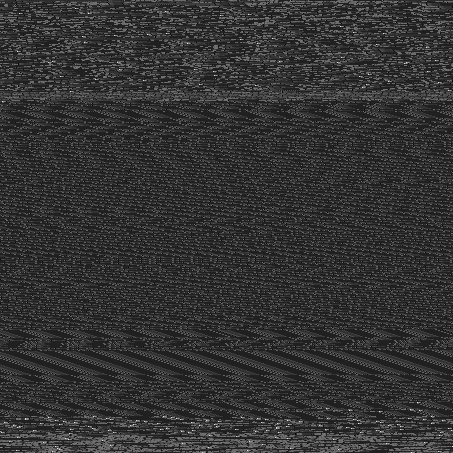

In [300]:
from IPython.display import Image 
Image(filename='asm_image/Happy99.png')

## First 200 Image Pixels

In [290]:
pip install opencv-python

     |████████████████████████████████| 63.0 MB 18 kB/s  eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [301]:
import cv2
imagefeatures = np.zeros((1000, 200)) # 10,868 files

In [302]:
for i, asmfile in enumerate(os.listdir("asmFiles")):
    img = cv2.imread("asm_image/" + asmfile.split('.')[0] + '.png')
    img_arr = img.flatten()[:200]
    imagefeatures[i, :] += img_arr

In [306]:
img_features_name = []
for i in range(200):
    img_features_name.append('pix' + str(i))
imgdf = pd.DataFrame(normalize(imagefeatures, axis = 0), columns = img_features_name)

TypeError: normalize() got an unexpected keyword argument 'axis'

In [304]:
imgdf['ID'] = result.ID

NameError: name 'imgdf' is not defined

In [305]:
imgdf.head()

NameError: name 'imgdf' is not defined

In [69]:
#import joblib
joblib.dump(imgdf, 'img_df')

['img_df']

In [70]:
img_df=joblib.load('img_df')

In [71]:
img_df.head()

,pix0,pix1,pix2,pix3,pix4,pix5,pix6,pix7,pix8,pix9,...,pix191,pix192,pix193,pix194,pix195,pix196,pix197,pix198,pix199,ID
0,0.033956,0.033956,0.033956,0.026343,0.026343,0.026343,0.027291,0.027291,0.027291,0.025929,...,0.031638,0.031638,0.031638,0.031638,0.031638,0.031638,0.031638,0.031638,0.031638,01azqd4InC7m9JpocGv5
1,0.021694,0.021694,0.021694,0.044286,0.044286,0.044286,0.042405,0.042405,0.042405,0.045756,...,0.031638,0.031638,0.031638,0.031638,0.031638,0.031638,0.031638,0.031638,0.031638,01IsoiSMh5gxyDYTl4CB
2,0.033956,0.033956,0.033956,0.026343,0.026343,0.026343,0.027291,0.027291,0.027291,0.025929,...,0.031638,0.031638,0.031638,0.031638,0.031638,0.031638,0.031638,0.031638,0.031638,01jsnpXSAlgw6aPeDxrU
3,0.033956,0.033956,0.033956,0.026343,0.026343,0.026343,0.027291,0.027291,0.027291,0.025929,...,0.031638,0.031638,0.031638,0.031638,0.031638,0.031638,0.031638,0.031638,0.031638,01kcPWA9K2BOxQeS5Rju
4,0.033956,0.033956,0.033956,0.026343,0.026343,0.026343,0.027291,0.027291,0.027291,0.025929,...,0.031638,0.031638,0.031638,0.031638,0.031638,0.031638,0.031638,0.031638,0.031638,01SuzwMJEIXsK7A8dQbl


## Important Feature Selection Using Random Forest

In [346]:
def imp_features(data, features, keep):
    rf = RandomForestClassifier(n_estimators = 100, n_jobs = -1)
    rf.fit(data, result_y)
    imp_feature_indx = np.argsort(rf.feature_importances_)[::-1]
    imp_value = np.take(rf.feature_importances_, imp_feature_indx[:20])
    imp_feature_name = np.take(features, imp_feature_indx[:20])
    sns.set()
    plt.figure(figsize = (10, 5))
    ax = sns.barplot(x = imp_feature_name, y = imp_value)
    ax.set_xticklabels(labels = imp_feature_name, rotation = 45)
    sns.set_palette(reversed(sns.color_palette("husl", 10)), 10)
    plt.title('Important Features')
    plt.xlabel('Feature Names')
    plt.ylabel('Importance')
    return imp_feature_indx[:keep]

## Important Features Among Opcode Bi-Gram

In [361]:
from sklearn.preprocessing import normalize
op_bi_indxes = imp_features(normalize(opcodebivect, axis = 0), asmopcodebigram(), 200)

In [362]:
op_bi_df = pd.DataFrame.sparse.from_spmatrix(normalize(opcodebivect, axis = 0), columns = asmopcodebigram())
for col in op_bi_df.columns:
    if col not in np.take(asmopcodebigram(), op_bi_indxes):
        op_bi_df.drop(col, axis = 1, inplace = True)

In [363]:
op_bi_df.sparse.to_dense().to_csv('op_bi_new.csv')

In [364]:
op_bi_df = pd.read_csv('op_bi_new.csv').drop('Unnamed: 0', axis = 1).fillna(0)

In [365]:
op_bi_df['ID'] = result.ID
op_bi_df.head()

,mov call,mov shl,mov ror,mov rol,mov jnb,mov jz,mov rtn,mov lea,mov movzx,retf jmp,...,imul call,imul shl,imul ror,imul rol,imul jnb,imul jz,imul rtn,movzx lea,movzx movzx,ID
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Happy99


## Important Features Among Opcode Tri-Gram

In [102]:
op_tri_indxes = imp_features(normalize(opcodetrivect, axis = 0), asmopcodetrigram(), 200)

In [103]:
op_tri_df = pd.DataFrame.sparse.from_spmatrix(normalize(opcodetrivect, axis = 0), columns = asmopcodetrigram())
op_tri_df = op_tri_df.loc[:, np.intersect1d(op_tri_df.columns, np.take(asmopcodetrigram(), op_tri_indxes))]

In [105]:
op_tri_df.sparse.to_dense().to_csv('op_tri.csv')
op_tri_df = pd.read_csv('op_tri.csv').drop('Unnamed: 0', axis = 1).fillna(0)
op_tri_df['ID'] = result.ID
op_tri_df.head()

,add cmp jmp,add cmp pop,add dec or,add mov add,add mov call,add mov cmp,add pop call,add pop mov,add pop pop,add pop retn,...,sub mov lea,sub mov movzx,sub shl push,sub xor pop,xor lea jmp,xor pop jmp,xor pop pop,xor push push,xor sub inc,ID
0,0.000000,0.002934,0.000000,0.005284,0.033581,0.002577,0.0,0.017739,0.001676,0.002246,...,0.051983,0.000000,0.128476,0.030275,0.0,0.0,0.001052,0.011010,0.0,01azqd4InC7m9JpocGv5
1,0.000000,0.005868,0.014228,0.003303,0.000000,0.001289,0.0,0.005913,0.000000,0.000749,...,0.006116,0.024547,0.000000,0.000000,0.0,0.0,0.001052,0.000000,0.0,01IsoiSMh5gxyDYTl4CB
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.016515,0.0,01jsnpXSAlgw6aPeDxrU
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.003058,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,01kcPWA9K2BOxQeS5Rju
4,0.003281,0.000000,0.000000,0.002642,0.000000,0.009450,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000918,0.0,01SuzwMJEIXsK7A8dQbl


## Important Features Among Opcode Tetra-Gram

In [108]:
op_tetra_indxes = imp_features(normalize(opcodetetravect, axis = 0), asmopcodetetragram(), 200)

In [109]:
op_tetra_df = pd.DataFrame.sparse.from_spmatrix(normalize(opcodetetravect, axis = 0), columns = asmopcodetetragram())
op_tetra_df = op_tetra_df.loc[:, np.intersect1d(op_tetra_df.columns, np.take(asmopcodetetragram(), op_tetra_indxes))]

In [110]:
op_tetra_df.sparse.to_dense().to_csv('op_tetra.csv')
op_tetra_df = pd.read_csv('op_tetra.csv').drop('Unnamed: 0', axis = 1).fillna(0)
op_tetra_df['ID'] = result.ID
op_tetra_df.head()

,add jmp mov jmp,add mov cmp jnb,add mov jmp mov,add mov mov add,add mov mov movzx,add mov mov push,add mov movzx mov,add pop call add,add pop lea push,add pop push mov,...,sub mov mov mov,sub mov mov push,sub shl mov or,sub shl push mov,xor cmp cmp jnb,xor lea jmp cmp,xor mov mov mov,xor pop call retn,xor retn mov push,ID
0,0.006994,0.000000,0.003532,0.005958,0.000000,0.003011,0.000000,0.0,0.0,0.0,...,0.012026,0.017061,0.0,0.064786,0.0,0.0,0.002660,0.0,0.0,01azqd4InC7m9JpocGv5
1,0.000000,0.000000,0.001766,0.004767,0.010269,0.004014,0.004865,0.0,0.0,0.0,...,0.013190,0.070681,0.0,0.000000,0.0,0.0,0.004939,0.0,0.0,01IsoiSMh5gxyDYTl4CB
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,01jsnpXSAlgw6aPeDxrU
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.002437,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,01kcPWA9K2BOxQeS5Rju
4,0.003497,0.086074,0.007065,0.069116,0.005134,0.032113,0.004865,0.0,0.0,0.0,...,0.027543,0.075556,0.0,0.000000,0.0,0.0,0.000380,0.0,0.0,01SuzwMJEIXsK7A8dQbl


## Important Features Among Byte Bi-Gram

In [377]:
byte_bi_indxes = imp_features(normalize(byte_bigram_vect, axis = 0), byte_bigram(), 400)

In [378]:
np.save('byte_bi_indx', byte_bi_indxes)
byte_bi_indxes = np.load('byte_bi_indx.npy')

In [382]:
top_byte_bi = np.zeros((1, 0))
for i in byte_bi_indxes:
    sliced = byte_bigram_vect[:, i].todense()
    top_byte_bi = np.hstack([top_byte_bi, sliced])

In [383]:
byte_bi_df = pd.DataFrame(top_byte_bi, columns = np.take(byte_bigram(), byte_bi_indxes))
byte_bi_df

,?? ??,55 95,55 b3,55 b2,55 b1,55 b0,55 af,55 ae,55 ad,55 ac,...,55 31,55 30,55 2f,55 2e,55 2d,55 2c,55 2b,55 2a,55 29,55 28
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [384]:
byte_bi_df.to_csv('byte_bi_new.csv')
byte_bi_df = pd.read_csv('byte_bi_new.csv').drop('Unnamed: 0', axis = 1).fillna(0)
byte_bi_df['ID'] = result.ID
byte_bi_df.head()

,?? ??,55 95,55 b3,55 b2,55 b1,55 b0,55 af,55 ae,55 ad,55 ac,...,55 30,55 2f,55 2e,55 2d,55 2c,55 2b,55 2a,55 29,55 28,ID
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Happy99


## Total Features

#### Adding 300 Byte bigram, 200 Opcode Bigram + Trigram + Tetragram (each), first 200 Image Pixels

In [387]:
# final_data = pd.concat([result_x, op_bi_df, op_tri_df, op_tetra_df, byte_bi_df,img_df], axis = 1, join = 'inner')
final_data = pd.concat([result_x, op_bi_df, byte_bi_df], axis = 1, join = 'inner')

final_data = final_data.drop('ID', axis = 1)
final_data.head()

,0,1,2,3,4,5,6,7,8,9,...,55 31,55 30,55 2f,55 2e,55 2d,55 2c,55 2b,55 2a,55 29,55 28
0,3412,60,55,96,36,34,19,36,20,8,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [388]:
final_data.to_csv('final_data_new.csv')
final_data = pd.read_csv('final_data_new.csv')

In [389]:
final_data

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,55 31,55 30,55 2f,55 2e,55 2d,55 2c,55 2b,55 2a,55 29,55 28
0,0,3412,60,55,96,36,34,19,36,20,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
